# Space4Time Proof of Concept

## Introduction

Land use changes have several consequences in the energetic budget of the earth system (CITE XX, IPCC XXX). For example, the deforestation of the tropical rain forest to increase the crops areas, as profound impacts on the carbon and water cycle at local, regional and global scales. For this reason, assessing the impact on climate biophysical variables produced by the change of land use is more relevant than ever in the current scenario of global warming and climate change. The space for time method relies on the local contrast of vegetation to disentangle the effect of land use changes on biophysical variables (CITE XXXX). In this notebook do we basic theoretical approach and show the technical implementation of the method.


## Space for time method

 Flow chart to be added!!
 
 


In [ ]:
using Pkg
# the path where you have the Manifest.toml and Project.toml 
Pkg.activate("/Net/Groups/BGI/people/dpabon/nfdi4earth_oemc")
# run the line below only once to install all the necessary packages (This will take a while!!)
#Pkg.instantiate()

Necessary packages:


In [ ]:
using YAXArrays
using DataFrames
using XLSX
using CSV
using Zarr
using NetCDF
using CairoMakie
using GeoMakie
using Statistics
using LinearAlgebra
using NamedArrays
using Combinatorics
using GLM
using BenchmarkTools
using ProgressMeter
using NetCDF
using Zarr
using Glob
using YAXArrayBase
using Dates
using Rasters
using Interpolations
using DiskArrayTools
using ColorSchemes
using Skipper
using Primes
using TiledViews
using Random
using Revise
using NeutralLandscapes

In [5]:
# Installing YAXArraysToolbox
#Pkg.add(url = "https://github.com/dpabon/YAXArraysToolbox.jl", dev = "main")

In [6]:
using YAXArraysToolbox

In [7]:
# the folder where you have the space4time function.

# the folder where the YAXArrays packages will allocate temporal files
YAXArrays.YAXdir("/Net/Groups/BGI/scratch/dpabon/YAXA_tmp")

#activating CairoMakie for plotting
CairoMakie.activate!()

## Generating a Land Cover Map

We will create a land cover map of 10 km by 10 km. Where we assume that 1 pixel = 1 meter.

In [8]:
edge = 10000

size_tile = (edge, edge)

(10000, 10000)

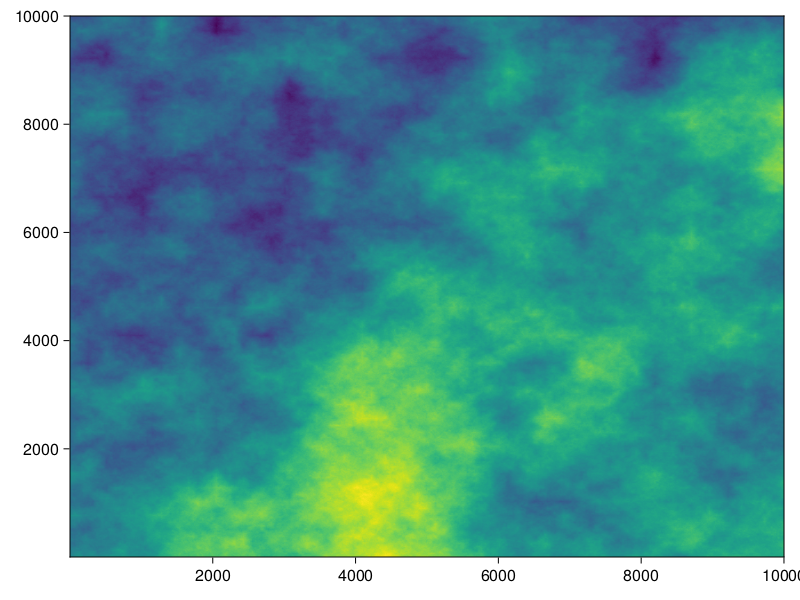

In [9]:
# spatial autocorrelation
Random.seed!(232323)
spatial_auto = 0.7
midpoint_sim = rand(MidpointDisplacement(spatial_auto), size_tile)
heatmap(midpoint_sim)

In [10]:
# Number of classes
n_classes = 3
classes_dist = NeutralLandscapes.classify(midpoint_sim, ones(n_classes));

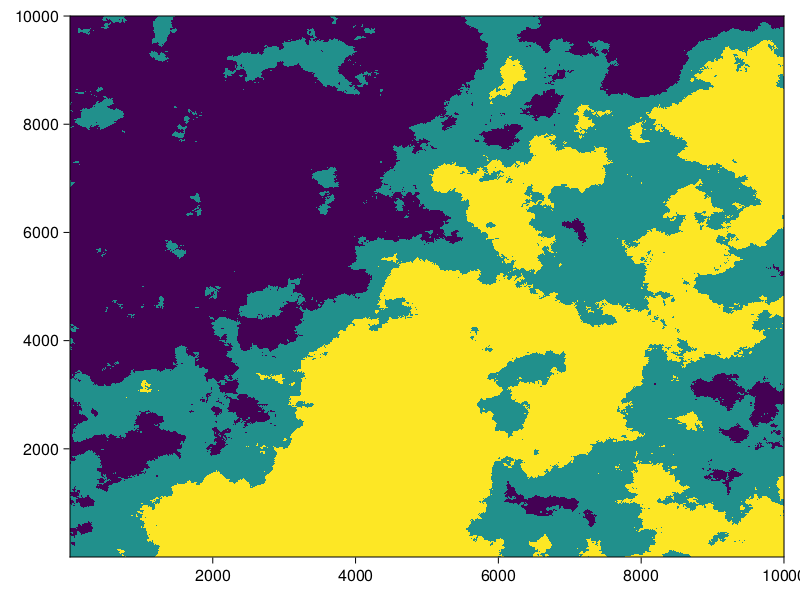

In [11]:
heatmap(classes_dist)

## Setting LST values per class

We will define a constant LST value for each class.

In [12]:
# defining lst per class

class_1_lst = 20.0

class_2_lst = 22.0

class_3_lst = 23.8

alllst = (class_1_lst, class_2_lst, class_3_lst)

#empty matrix
lst = fill(NaN, size_tile)

for i in eachindex(alllst)
    lst[findall(==(i), classes_dist)] .= alllst[i]
end

## Spatial-resampling

Usually, land cover maps are at lower spatial resolution than 1 meter. Then, we will aggregate the data in a new spatial resolution and estimate the frequency of each one of the classes per pixel.

### Spatial-resampling for the discrete classes

In [13]:
# New spatial resolution in meters
size_pixel_new = 100 

# in this case each pixel will be composed of 100 pixels.

# we will use Tiled View to create a view of each one of the new pixels
a = TiledView(classes_dist, (size_pixel_new, size_pixel_new),(0, 0); keep_center = false)

# we will create an array with the new resolution to save the results
new_res_array_classes = fill(0., (size_pixel_new, size_pixel_new, n_classes))

for i in 1:size_pixel_new
    for j in 1:size_pixel_new
        for c in 1:n_classes
            new_res_array_classes[i,j,c] = count(==(c), a[:,:,i,j]) / (size_pixel_new^2)
        end
    end
end

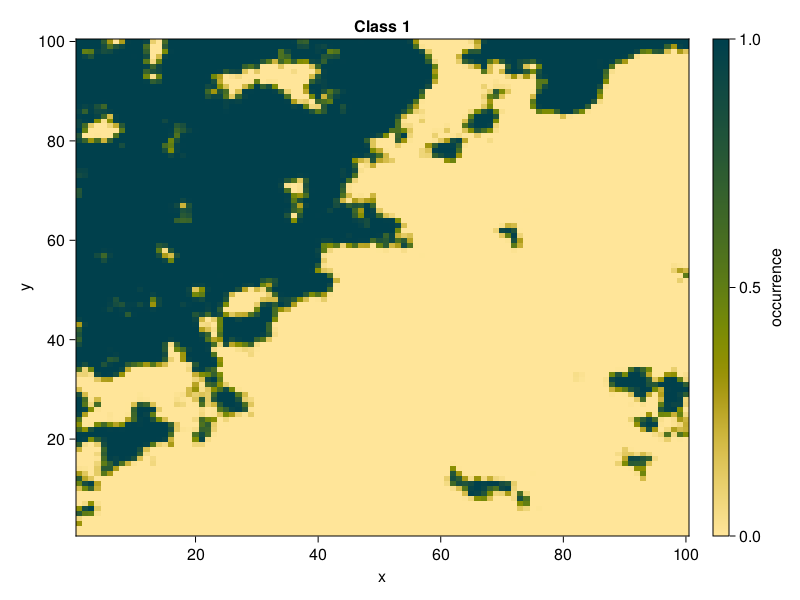

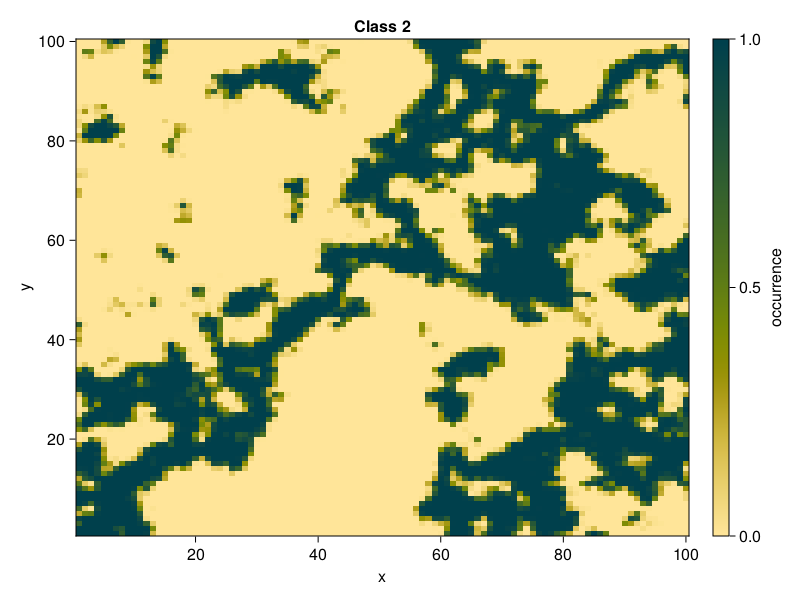

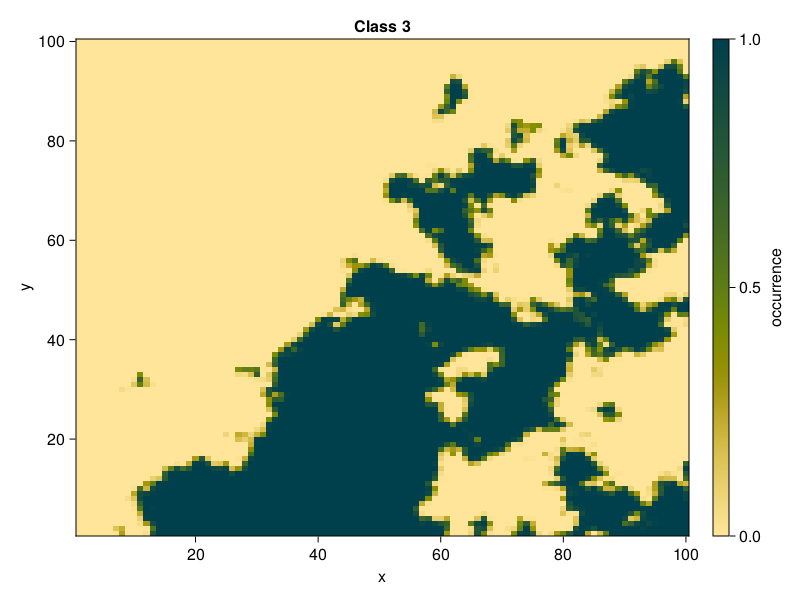

In [14]:
# plotting the occurrence of each one of the classes

for i in 1:n_classes
    fig = Figure()
    ax = Axis(fig[1, 1]; xlabel = "x", ylabel = "y", title = "Class " * string(i))
    temp = heatmap!(new_res_array_classes[:,:,i], colormap = Reverse(:bamako))
    Colorbar(fig[1, 2], temp, label = "occurrence")
    display(fig)
end


### Spatial-resampling for the LST product

In [15]:
# we will use Tiled View to create a view of each one of the new pixels
a = TiledView(lst, (size_pixel_new, size_pixel_new),(0, 0); keep_center = false)

# we will create an array with the new resolution to save the results
new_res_array_lst = fill(NaN, (size_pixel_new, size_pixel_new))

for i in 1:size_pixel_new
    for j in 1:size_pixel_new
        new_res_array_lst[i,j] = mean(a[:,:,i,j])
    end
end
        

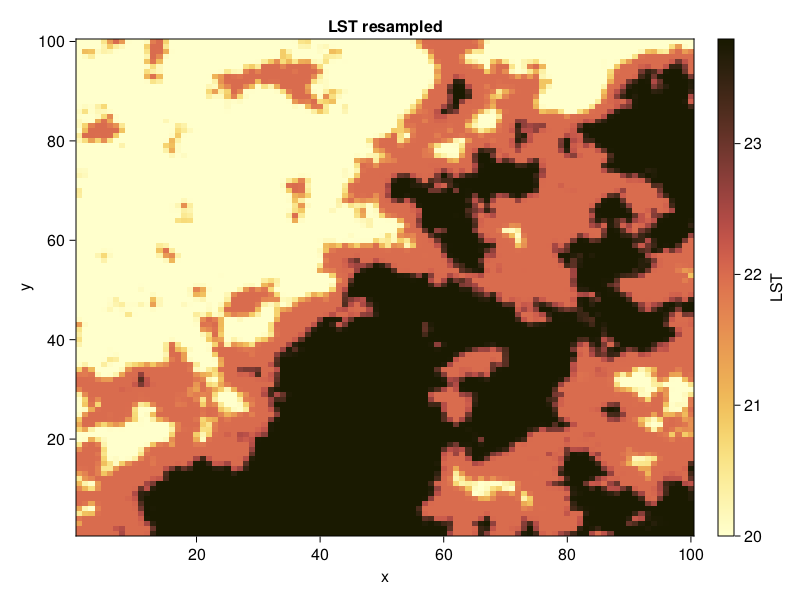

In [16]:
fig = Figure()
ax = Axis(fig[1, 1]; xlabel = "x", ylabel = "y", title = "LST resampled")
temp = heatmap!(new_res_array_lst[:,:], colormap = :lajolla)
Colorbar(fig[1, 2], temp, label = "LST")
fig

## Organizing the data in YAXArray objects

Land Cover Cube

In [17]:
 
# axis
axlist = [
    RangeAxis("x", 1:size(new_res_array_classes)[1]),
    RangeAxis("y", 1:size(new_res_array_classes)[2]),
    CategoricalAxis("Classes", ["class" * string(i) for i in 1:n_classes])]
# YAXArray Cube
lcc_cube = YAXArray(axlist, new_res_array_classes)

YAXArray with the following dimensions
x                   Axis with 100 Elements from 1 to 100
y                   Axis with 100 Elements from 1 to 100
Classes             Axis with 3 elements: class1 class2 class3 
Total size: 234.38 KB


LST Cube

In [18]:
#axis
axlist = [
    RangeAxis("x", 1:size(new_res_array_classes)[1]),
    RangeAxis("y", 1:size(new_res_array_classes)[2])]

# YAXArray Cube
lst_cube = YAXArray(axlist, new_res_array_lst)

YAXArray with the following dimensions
x                   Axis with 100 Elements from 1 to 100
y                   Axis with 100 Elements from 1 to 100
Total size: 78.12 KB


## Running space4time

In [19]:
results_space4time = space4time_proc(lst_cube, lcc_cube; time_axis_name = nothing, lon_axis_name = "x", lat_axis_name = "y", classes_var_name = "Classes", winsize = 5, minpxl = 25, minDiffPxlspercentage = 0., classes_vec = ["class" * string(i) for i in 1:n_classes], max_value = 1, showprog = true, max_cache = 1e8)

YAXArray Dataset
Dimensions: 
   time                Axis with 1 Elements from 1 to 1
   transitions         Axis with 3 elements: class1 to class2 class1 to class3 class2 to class3 
   classes             Axis with 3 elements: class1 class2 class3 
   summary_stat        Axis with 3 elements: rsquared cumulative_variance predicted 
   Differences         Axis with 3 elements: delta delta_error coocurence 
   y                   Axis with 100 Elements from 1 to 100
   Values_of_Z_for_pure_classesAxis with 2 elements: estimated estimated_error 
   x                   Axis with 100 Elements from 1 to 100
Variables: SummaryStats metrics_for_classes metrics_for_transitions 

In [20]:
results_space4time.metrics_for_transitions

YAXArray with the following dimensions
time                Axis with 1 Elements from 1 to 1
transitions         Axis with 3 elements: class1 to class2 class1 to class3 class2 to class3 
Differences         Axis with 3 elements: delta delta_error coocurence 
x                   Axis with 100 Elements from 1 to 100
y                   Axis with 100 Elements from 1 to 100
Total size: 703.12 KB


## Filtering the results using $R^2$ and co-occurrence

In [21]:
metrics_transitions_cube = results_space4time.metrics_for_transitions

YAXArray with the following dimensions
time                Axis with 1 Elements from 1 to 1
transitions         Axis with 3 elements: class1 to class2 class1 to class3 class2 to class3 
Differences         Axis with 3 elements: delta delta_error coocurence 
x                   Axis with 100 Elements from 1 to 100
y                   Axis with 100 Elements from 1 to 100
Total size: 703.12 KB


In [22]:
masking_without_delta = masking_proc(results_space4time.metrics_for_transitions; 
cube_rsquared = results_space4time.SummaryStats[summary_stat = "rsquared"], rsquared_thr = 0.2, 
cube_co_occurrence = results_space4time.metrics_for_transitions[Differences = "coocurence"], co_occurence_thr = 0.5, 
cube_delta = nothing, time_dim = "time", showprog = true)

YAXArray with the following dimensions
time                Axis with 1 Elements from 1 to 1
transitions         Axis with 3 elements: class1 to class2 class1 to class3 class2 to class3 
Differences         Axis with 3 elements: delta delta_error coocurence 
x                   Axis with 100 Elements from 1 to 100
y                   Axis with 100 Elements from 1 to 100
Total size: 703.12 KB


## Plotting the results

First we will compared the distribution of the delta values vs the LST defined at the beggining for discrete class.

In [23]:
delta_1_org = abs(class_1_lst - class_2_lst)
delta_2_org = abs(class_1_lst - class_3_lst)
delta_3_org = abs(class_2_lst - class_3_lst);

In [24]:
vec_delta_orig = Array{Float64}(reshape(masking_without_delta[1,:,1,:,:], (Int(edge/size_pixel_new)^2 * n_classes)))
vec_delta_plot = vec_delta_orig[findall(!isnan, vec_delta_orig)]
vec_index = repeat(1:n_classes, outer = (Int(edge/size_pixel_new)^2*n_classes))
vec_index = vec_index[findall(!isnan, vec_delta_orig)];

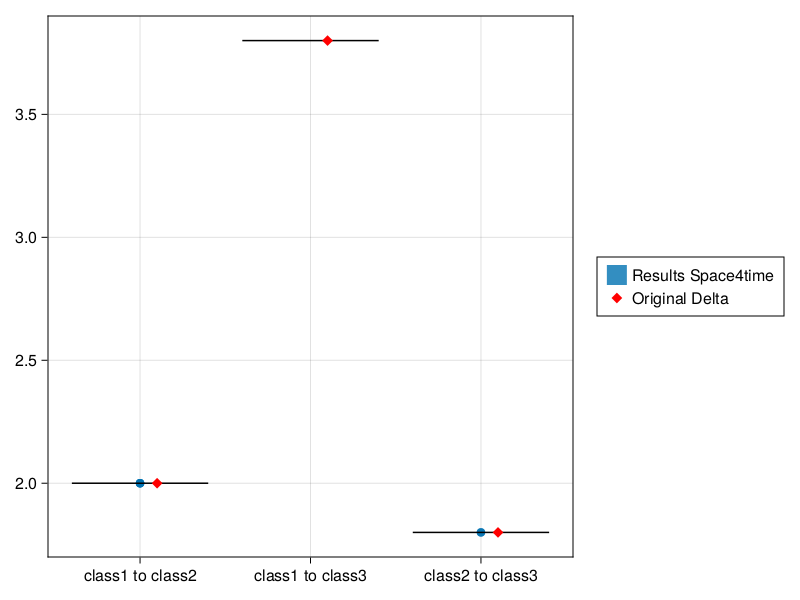

In [25]:
transitions = getAxis("transitions", masking_without_delta)
fig = Figure()
ax = Axis(fig[1,1], xticks = (1:length(transitions), transitions))
temp = boxplot!(ax, vec_index, vec_delta_plot)
temp2 = scatter!(ax, [i + 0.1 for i in 1:n_classes], [delta_1_org, delta_2_org, delta_3_org], marker = :diamond, color = :red)
Legend(fig[1, 2],
    [temp, temp2],
    ["Results Space4time", "Original Delta"])
fig

Let's check the spatial distribution of the LST changes produced by the change of classes.

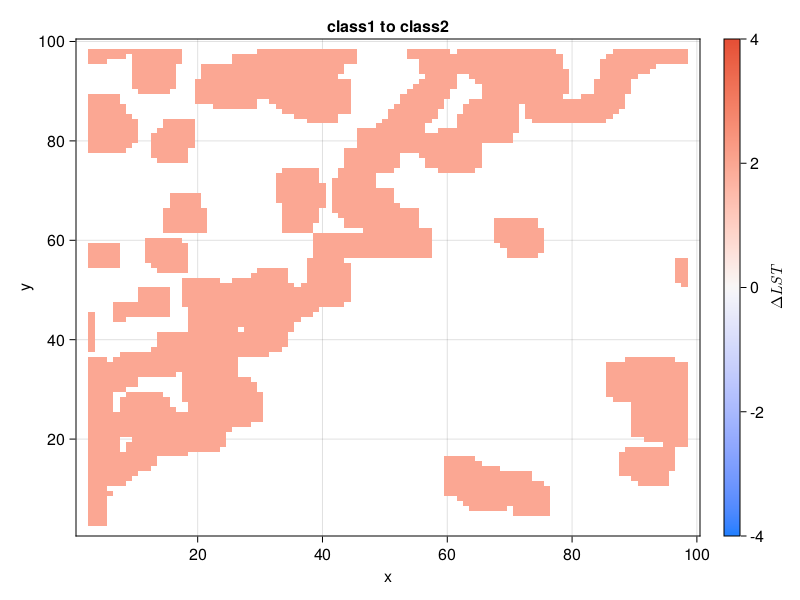

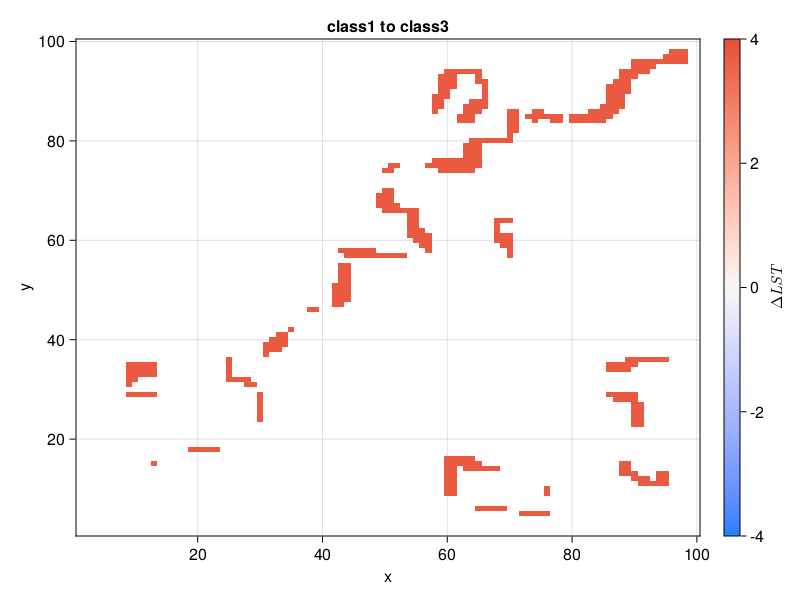

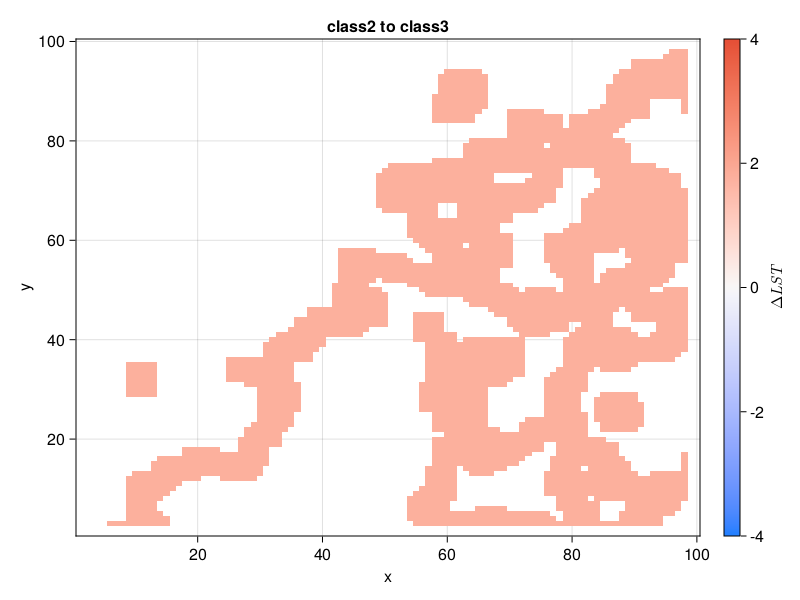

In [26]:
transitions = getAxis("transitions", masking_without_delta)

for i in eachindex(transitions)
    fig = Figure()
    ax = Axis(fig[1, 1]; xlabel = "x", ylabel = "y", title = transitions[i])
    temp = heatmap!(masking_without_delta[1,i,1,:,:], colormap = :diverging_bwr_55_98_c37_n256, colorrange = (-4,4))
    Colorbar(fig[1, 2], temp, label = L"\Delta LST")
    display(fig)
end

## Conclusion

The space4time technique allows estimating the differences in biophysical variables produced by changes in land cover classes.